In [1]:
import os
import sys
import time
import glob
import json
import pytz
import numpy as np
import logging
import seaborn as sns
import argparse
import datetime
import graphviz
import networkx as nx
import matplotlib.pyplot as plt

import torch #基本モジュール
from torch.autograd import Variable #自動微分用
import torch.nn as nn #ネットワーク構築用
import torch.optim as optim #最適化関数
import torch.nn.functional as F #ネットワーク用の様々な関数
import torch.utils.data #データセット読み込み関連
import torchvision #画像関連
from torchvision import datasets, models, transforms #画像用データセット諸々
import torch.backends.cudnn as cudnn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# utils

## other

In [3]:
def argspace(**kwds):
  def deco(f):
    def inner(**ikwds):
      kwds.update(ikwds)
      return f(argparse.Namespace(**kwds))
    return inner
  return deco

In [4]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

In [5]:
class Singleton(object):
  def __new__(cls, *args, **kargs):
    if not hasattr(cls, "_instance"):
      cls._instance = super(Singleton, cls).__new__(cls)
    return cls._instance

In [6]:
class Experiment(Singleton):
  def __init__(self):
    if not hasattr(self, 'func'):
      self.func = {}
  
  def _store(self, key, f, order):
    self.func.setdefault(key, {})
    self.func[key].update({f.__name__:(order, f)})

  def __call__(self, key):
    def f(*args, **kwds):
      funcs = sorted(self.func[key].values(), key=lambda x: x[0])
      return [g(*args, **kwds) for _, g in funcs]
    return f

  def event(*key, order=0):
    def d(f):
      for k in key:
        Experiment()._store(k, f, order)
      def inner(*args, **kwds):
        return f(*args, **kwds)
      return inner
    return d
  
  def reset():
    Experiment().func = {}

## metrics

In [7]:
def accuracy(output, target, topk=(1,)):
  maxk = max(topk)
  batch_size = target.size(0)

  _, pred = output.topk(maxk, 1, True, True)
  pred = pred.t()
  correct = pred.eq(target.view(1, -1).expand_as(pred))

  res = []
  for k in topk:
    correct_k = correct[:k].view(-1).float().sum(0)
    res.append(correct_k.mul_(100.0/batch_size))
  return res

In [8]:
class AvgrageMeter(object):

  def __init__(self):
    self.reset()

  def reset(self):
    self.avg = 0
    self.sum = 0
    self.cnt = 0

  def update(self, val, n=1):
    self.sum += val * n
    self.cnt += n
    self.avg = self.sum / self.cnt

In [9]:
class Metrics():
  def __init__(self, model, dataloader):
    self._run(model, dataloader)
    self.epsilon = 1e-7
  
  @torch.no_grad()
  def _run(self, model, dataloader):
    data, target = next(iter(dataloader))
    device =  next(model.parameters()).device
    print(device)
    num = target.max().long() + 1
    cm = torch.zeros(num, num).to(device)

    for i, (data, target) in enumerate(dataloader):
      data = data.to(device)
      target = target.to(device)
      outputs = model(data)
      _, preds = torch.max(outputs, 1)
      for t, p in zip(target.view(-1), preds.view(-1)):
        cm[t.long(), p.long()] += 1

    self.matrix = cm
    self.dim = num
    self.sum0 = self.matrix.sum(0)
    self.sum1 = self.matrix.sum(1)
    self.sum = self.matrix.sum()

  def confusion_matrix(self):
    return self.matrix

  def TP(self, index):
    return self.matrix[index][index]

  def FN(self, index):
    return self.sum1[index] - self.TP(index)

  def FP(self, index):
    return self.sum0[index] - self.TP(index)

  def TN(self, index):
    return self.sum - self.TP(index) - self.FN(index) - self.FP(index)

  def _sum(self, F):
    return sum(F(i) for i in range(self.dim))
    
  def _micro(self, F, G):
    return self._sum(F) / (self._sum(F) + self._sum(G) + self.epsilon)

  def _macro(self, F, G):
    return sum(F(i) / (F(i) + G(i) + self.epsilon) for i in range(self.dim)) / self.dim

  def _switch(self, F, G, micro):
    return (self._micro(F, G) if micro else self._macro(F, G))

  def accuracy(self, micro=True):
    return (self._sum(self.TP) / self.sum if micro else 
            (sum(self.TP(i) / self.sum1 for i in range(self.dim)) / self.dim).mean())

  def precision(self, micro=True):
    return self._switch(self.TP, self.FP, micro)

  def recall(self, micro=True):
    return self._switch(self.TP, self.FN, micro)

  def specificity(self, micro=True):
    return self._switch(self.TN, self.FP, micro)

  def f_measure(self, micro=True):
    p, r = self.precision(micro), self.recall(micro)
    return 2 * p * r / (p + r + self.epsilon)

  def print(self):
    print(self.confusion_matrix())
    print("accuracy ", self.accuracy(), self.accuracy(micro=False))
    print("precision ", self.precision(), self.precision(micro=False))
    print("recall ", self.recall(), self.recall(micro=False))
    print("specificity ", self.specificity(), self.specificity(micro=False))
    print("f_measure ", self.f_measure(), self.f_measure(micro=False))

## save

In [10]:
def path_with_time(path : str) -> str:
  dt_now = datetime.datetime.now(pytz.timezone('Asia/Tokyo'))
  return '{}-{}'.format(path, dt_now.strftime('%Y-%m-%d_%H-%M-%S'))

In [11]:
def create_exp_dir(path, scripts_to_save=None):
  if not os.path.exists(path):
    os.mkdir(path)
  print('Experiment dir : {}'.format(path))

  if scripts_to_save is not None:
    os.mkdir(os.path.join(path, 'scripts'))
    for script in scripts_to_save:
      dst_file = os.path.join(path, 'scripts', os.path.basename(script))
      shutil.copyfile(script, dst_file)

In [12]:
def init_logging(save_path):
  class Formatter(logging.Formatter):
      """override logging.Formatter to use an aware datetime object"""
      def converter(self, timestamp):
          dt = datetime.datetime.fromtimestamp(timestamp)
          tzinfo = pytz.timezone('Asia/Tokyo')
          return tzinfo.localize(dt)
          
      def formatTime(self, record, datefmt=None):
          dt = self.converter(record.created)
          if datefmt:
              s = dt.strftime(datefmt)
          else:
              try:
                  s = dt.isoformat(timespec='milliseconds')
              except TypeError:
                  s = dt.isoformat()
          return s

  log_format = '%(asctime)s %(message)s'
  logging.basicConfig(stream=sys.stdout, level=logging.INFO,
      format=log_format, datefmt='%m/%d %I:%M:%S %p')
  fh = logging.FileHandler(os.path.join(save_path, 'log.txt'))
  fh.setFormatter(Formatter(log_format))
  logging.getLogger().addHandler(fh)

In [13]:
def save_dir(dir : str, drivepath = './drive/My Drive/ml'):
  if not dir: return

  import subprocess
  res = subprocess.run(["cp", "-r", "./" + dir, drivepath], stdout=subprocess.PIPE)
  sys.stdout.write(res.stdout)

In [14]:
class Store():
  def __init__(self, dir="result", name="log", fig=[]):
    self.dict = {}
    self.dir = dir
    self.name = name
    self.fig = fig
  
  def add(self, name, value):
    if not name in self.dict:
      self.dict[name] = []
    self.dict[name].append(value)
  
  def update(self, store : 'Store'):
    self.dict.update(store.dict)

  def save(self):
    self.save_log()
    for metrix, x, y in self.fig:
      self.save_fig(metrix, x, y)

  def save_log(self, name=None):
    name = name if name else self.name
    path = os.path.join(self.dir, name + ".txt")
    with open(path, mode='w') as f:
      f.write("%s" % self.dict)

  def save_fig(self, metrix, xlabel, ylabel, show=True):
    fig = plt.figure()

    if type(metrix) is str:
      times = len(self.dict[metrix])
      plt.plot(np.arange(times), self.dict[metrix])
    else :
      times = len(self.dict[metrix[0]])
      for m in metrix:
        plt.plot(np.arange(times), self.dict[m], label=m)
      metrix = "_".join(metrix)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    if show: plt.show()
    fig.savefig(os.path.join(self.dir, "%s_%d.png" % (metrix, times)))

  def __repr__(self):
    return "store in %s" % self.dict

# dataset

In [15]:
def load_dataset(train=2000, test=500, valid=0):
  #画像の変形処理
  transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
  ])

  transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
  ])

  dataset = torchvision.datasets.CIFAR10
  kwargs = {"root" : "./data", "download" : True}

  #CIFAR-10のtrain, testsetのロード
  trainset = dataset(train=True, transform=transform, **kwargs)
  testset = dataset(train=False, transform=transform_test, **kwargs)
  
  trainset, validset, _ = torch.utils.data.random_split(trainset, [train, valid, 50000-train-valid])
  testset, _ = torch.utils.data.random_split(testset, [test, 10000-test])
  return argparse.Namespace(train=trainset, test=testset, valid=validset)

In [16]:
def load_dataloader(args):
  kwargs = {'num_workers': 1, 'pin_memory': True} if args.use_cuda else {}
  args.valid_size = args.valid_size if args.valid_size else 0
  sets = load_dataset(train=args.train_size, test=args.test_size, valid=args.valid_size)
  trainloader = torch.utils.data.DataLoader(sets.train, batch_size=args.batch_size, shuffle=True, **kwargs)
  validloader = torch.utils.data.DataLoader(sets.valid, batch_size=args.batch_size, shuffle=True, **kwargs)
  testloader = torch.utils.data.DataLoader(sets.test, batch_size=args.batch_size, shuffle=False, **kwargs)
  return argparse.Namespace(train=trainloader, test=testloader, valid=validloader)

# model

## sampler

In [17]:
class ArchitectureSampler():
  def __call__(self, graph : nx.DiGraph, alpha : torch.Tensor) -> nx.DiGraph:
    return self.graph(graph, alpha)

In [18]:
class MaxSampler(ArchitectureSampler):
  def graph(self, graph, alpha):
    G = nx.DiGraph(graph)
    n = G.number_of_nodes()

    for j in range(1, n):
      edges = [(i, j) for i in G.predecessors(j)]
      alphas = [alpha[i, j].item() for i, j in edges]
      edge_num = round(sum(alphas))
      disable = sorted(zip(edges, alphas), key=lambda x: x[-1])[:-edge_num]
      G.remove_edges_from([i for i, _ in disable])

    return G

In [19]:
class ForwardSampler(ArchitectureSampler):
  def graph(self, graph, alpha):
    G = nx.DiGraph(graph)
    n = G.number_of_nodes()

    for j in range(1, n):
      edges = [(i, j) for i in G.predecessors(j) if not i + 1 == j]
      G.remove_edges_from(edges)

    return G

In [20]:
class StrideCutSampler(ArchitectureSampler):
  def __init__(self, stride_max=8):
    assert stride_max >= 1
    self.stride = stride_max

  def graph(self, graph, alpha):
    G = nx.DiGraph(graph)
    n = G.number_of_nodes()

    for j in range(1, n):
      edges = [(i, j) for i in G.predecessors(j) if G.edges[i, j]['stride'] > self.stride]
      G.remove_edges_from(edges)

    return G

In [21]:
# model = load_model(dir="", gene='VGG19')
# g = model.graph
# sampler = StrideCutSampler(2)
# h = model.sampled_graph(sampler)
# render_graph(h, 'graph')
# # nx.graph_edit_distance(g, h)

## module

### component

In [22]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [23]:
class FactorizedReduce(nn.Module):
  def __init__(self, channel_in, channel_out, stride, affine=True):
    super(FactorizedReduce, self).__init__()
    assert channel_out % stride == 0
    
    self.convs = nn.ModuleList([
      nn.Conv2d(channel_in, channel_out // stride, 1, stride=stride, padding=0, bias=False)
      for _ in range(stride)
    ])
    self.bn = nn.BatchNorm2d(channel_out, affine=affine)

  def forward(self, x):
    # strideの偶奇による情報ロスを防ぐ
    out = torch.cat([conv(x[:,:,i:,i:]) for i, conv in enumerate(self.convs)], dim=1)
    out = self.bn(out)
    return out

In [24]:
class Shortcut(nn.Module):
  def __init__(self, in_channel, out_channel, stride):
    super(Shortcut, self).__init__()
    self.f = self._shortcut(in_channel, out_channel, stride)

  def forward(self, x):
    return self.f(x)

  def _shortcut(self, channel_in, channel_out, stride):
    if stride > 1:
      return FactorizedReduce(channel_in, channel_out, stride)
    elif channel_in != channel_out:
      return nn.Conv2d(channel_in, channel_out, 
                       kernel_size=1, stride=stride, padding=0)
    else:
      return lambda x: x

In [25]:
class Block(nn.Module):
  def __init__(self, graph, index):
    super(Block, self).__init__()
    node = graph.nodes[index]
    edges = [(i, index, graph.edges[i, index]) for i in graph.predecessors(index)]

    self.index = index
    self.indices = [i for i, _, _ in edges]
    self.edges = nn.ModuleList([self._build_module(s) for i, j, s in edges])

    process = [nn.ReLU(inplace=True)]
    if node['pool']: process += [nn.MaxPool2d(kernel_size=2, stride=2)]
    self.post_process = nn.Sequential(*process)

  def _build_module(self, setting):
    module = setting['module']
    in_channel, out_channel = setting['channel']
    stride = setting['stride']
    if module == 'forward':
      return nn.Sequential(
          nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1),
          nn.BatchNorm2d(out_channel)
          )
    elif module == 'shortcut':
      return Shortcut(in_channel, out_channel, stride)
    else:
      raise ValueError("module name")

  def forward(self, inputs, alpha):
    output = sum(alpha[i] * F(inputs[i]) for i, F in zip(self.indices, self.edges))
    return self.post_process(output)

### network

In [42]:
# 前提条件 : make graph, modules(Block, pool, ...)
# 拘束条件 : alpha sofmax
class Network(nn.Module):
  def __init__(self, gene, graph=None, preprocess : ArchitectureSampler=None):
    super(Network, self).__init__()
    self.gene = gene
    self.evaluate = bool(graph)
    self.graph = graph if graph else self._make_graph(gene)
    self.graph = preprocess(self.graph, None) if preprocess else self.graph

    self.blocks = nn.ModuleList(self._make_blocks(self.graph))
    self.pool = nn.AvgPool2d(kernel_size=1, stride=1)
    self.classifier = nn.Linear(512, 10)

  def _make_graph(self, gene, color_channel=3):
    
    def _decode_gene(gene):
      ch, st = [], []
      for g in gene:
        if g == 'M':
          st[-1] *= 2
        else :
          ch += [g]
          st += [1]
      return ch, st

    def __pi(array):
      r = []
      s = 1
      for q in array:
        s *= q
        r += [s]
      return r

    channel, stride = _decode_gene(gene)
    channel = [color_channel] + channel
    stride = [1] + stride
    s_stride = __pi(stride)

    n = len(channel)
    nodes = [(i, {'channel':channel[i], 'stride':s_stride[i], 'pool':stride[i]>1}) for i in range(n)]
    nodes[0][-1].update({'name':'input'})
    edges = [(i, j, {}) for i in range(n) for j in range(n) if i < j and not (i == 0 and j > 1)]
    for (i, j, d) in edges:
      d.update({
        'module' : 'forward' if i + 1 == j else 'shortcut', 
        'channel' : (nodes[i][-1]['channel'], nodes[j][-1]['channel']),
        'stride' : int(nodes[j-1][-1]['stride'] / nodes[i][-1]['stride'])
      })

    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    return G

  def _make_blocks(self, graph):
    return [Block(graph, i) for i in graph.nodes() if i > 0]

  def init_alpha(self, device):
    def _init_alpha(node_num, device, delta=1e-3):
      noise = delta * torch.randn(node_num, node_num, device=device)
      alpha = noise.clone().detach().requires_grad_(True)
      return [alpha]

    def _mask(node_num, device, name):
      mask = torch.zeros(node_num, node_num, device=device)

      for i, j in self.graph.edges():
        op = self.graph.edges[i, j]['module']
        if not op == name: continue

        mask[i, j] = 1

      return mask.t() > 0

    n = self.graph.number_of_nodes()
    self.alphas = _init_alpha(n, device)
    self.mask_s = _mask(n, device, 'shortcut')
    self.mask_f = _mask(n, device, 'forward')

    self.alphas += [torch.ones(n, device=device, requires_grad=True)]

    return self

  def normalized_alpha(self):
    alpha = torch.zeros_like(self.alphas[0])
    if self.evaluate:
      for i, j in self.graph.edges():
        alpha[j, i] = 1.0
    else:
      alpha[self.mask_f] = 1.0
      for a, raw, mask, b in zip(alpha, self.alphas[0], self.mask_s, self.normalized_beta()):
        a[mask] = b * F.softmax(raw[mask], dim=0)
    return alpha

  def normalized_beta(self):
    # f = lambda x : math.exp(x - 1) if x < 1 else math.log(x) + 1
    # return self.beta().apply_(f)
    x = self.beta()
    m = x>1
    beta = torch.zeros_like(x)
    beta[m] = torch.log(x[m]) + 1
    beta[~m] = torch.exp(x[~m] - 1)
    return beta

  def beta(self):
    return self.alphas[1]

  def sampled_graph(self, sampler : ArchitectureSampler):
    return sampler(self.graph, self.matrix_alpha())

  @torch.no_grad()
  def matrix_alpha(self, normalize=True):
    return (self.normalized_alpha() if normalize else self.alphas[0]).t()


  def forward(self, x):
    state = [x]
    alpha = self.normalized_alpha()

    for block in self.blocks:
      x = block(state, alpha[block.index])
      state += [x]

    out = self.pool(x)
    out = out.view(out.size(0), -1)
    out = self.classifier(out)
    return out

## others

In [27]:
class Architect():
  def __init__(self, valid_loader, model, criterion, lr, device):
    self.valid_loader = valid_loader
    self.model = model
    self.criterion = criterion
    self.optimizer = optim.Adam(model.alphas, lr=lr, betas=(0.5, 0.999), weight_decay=1e-3)
    self.device = device
    self.train = True

  def step(self):
    if not self.train: return
    
    data_v, target_v = next(iter(self.valid_loader))
    data_v, target_v = data_v.to(self.device), target_v.to(self.device)

    self.optimizer.zero_grad()
    output = self.model(data_v)
    loss = self.criterion(output, target_v)
    loss.backward()
    self.optimizer.step()

In [28]:
def render_graph(graph, path):
  format = dict(
      format='png', 
      edge_attr=dict(fontsize='20', fontname="times"),
      node_attr=dict(style='filled', shape='rect', align='center', fontsize='20', height='0.5', width='0.5', penwidth='2', fontname="times"),
      engine='dot' # circo, dot, fdp, neato, osage, sfdp, twopi
  )

  dg = graphviz.Digraph(**format)

  dg.attr('node', fillcolor='dodgerblue4', fontcolor='white', fontsize='15') # coral, 
  for node in graph.nodes():
    attr = graph.nodes[node]
    label = attr['name'] if 'name' in attr else str(node)
    label += '\n(%s, %d, %d)' % (attr['channel'], 32 / attr['stride'], 32 / attr['stride'])
    dg.node(str(node), label=label)

  for (i, j) in graph.edges():
    attr = graph.edges[i, j]
    label = attr['module']
    label = ""
    style = 'bold' if attr['module'] == 'forward' else 'dashed'
    dg.edge(str(i), str(j), label=label, style=style)

  dg.render(path)
  return dg

In [29]:
def save_heatmap(data : torch.tensor, path, format='1.2f'):
  plt.figure()
  data = data.detach().cpu().clone().numpy()
  sns.heatmap(data, annot=True, fmt=format)
  plt.savefig(path)
  plt.close('all')

# learning

## events

In [30]:
@Experiment.event('setup')
def setup(args):
  args.save = path_with_time(args.save)
  create_exp_dir(args.save, scripts_to_save=glob.glob('*.py'))
  init_logging(args.save)
  logging.info('kwargs %s' % args)
  
  args.start_epoch = 0

  # log init
  fig = [(["train_acc", "test_acc"], "epochs", "accuracy[%]"),
         (["train_loss", "test_loss"], "epochs", "loss")]
  store = Store(dir=args.save, name="store", fig=fig)
  args.store = store

  set_seed(args.seed)

In [31]:
@Experiment.event('setup')
def set_device(args):
  # cuda init
  args.use_cuda = torch.cuda.is_available()
  args.device = torch.device("cuda" if args.use_cuda else "cpu")

In [32]:
@Experiment.event('checkpoint', 'end', order=1)
def save_checkpoint(args):
  args.store.save()
  save_dir(args.save)

In [33]:
@argspace(retain_graph=True)
def train(args):
  objs = AvgrageMeter()
  top1 = AvgrageMeter()
  top5 = AvgrageMeter()
  args.model.train()

  for step, (input, target) in enumerate(args.dataset):
    n = input.size(0)

    input = Variable(input, requires_grad=False).to(args.device)
    target = Variable(target, requires_grad=False).to(args.device)

    args.architect.step()

    args.optimizer.zero_grad()
    logits = args.model(input)
    loss = args.criterion(logits, target)

    loss.backward(retain_graph=args.retain_graph)
    # nn.utils.clip_grad_norm(model.parameters(), args.grad_clip)
    args.optimizer.step()

    prec1, prec5 = accuracy(logits, target, topk=(1, 5))
    objs.update(loss.item(), n)
    top1.update(prec1.item(), n)
    top5.update(prec5.item(), n)

    if step % args.report_freq == 0:
      logging.info('train %03d %e %f %f', step, objs.avg, top1.avg, top5.avg)

  return top1.avg, objs.avg

In [34]:
@argspace()
def infer(args):
  objs = AvgrageMeter()
  top1 = AvgrageMeter()
  top5 = AvgrageMeter()
  args.model.eval()

  for step, (input, target) in enumerate(args.dataset):
    input = Variable(input, requires_grad=False).to(args.device)
    target = Variable(target, requires_grad=False).to(args.device)

    logits = args.model(input)
    loss = args.criterion(logits, target)

    prec1, prec5 = accuracy(logits, target, topk=(1, 5))
    n = input.size(0)
    objs.update(loss.item(), n)
    top1.update(prec1.item(), n)
    top5.update(prec5.item(), n)

    if step % args.report_freq == 0:
      logging.info('valid %03d %e %f %f', step, objs.avg, top1.avg, top5.avg)

  return top1.avg, objs.avg

## experiment

In [35]:
@argspace(gene='VGG11', stride_max=0, graph=None, dir=None)
def load_model(args):
  
  # init
  set_device(args)
  device = args.device

  # model setup
  gene = cfg[args.gene]
  sampler = StrideCutSampler(args.stride_max) if args.stride_max > 0 else None
  model = Network(gene, graph=args.graph, preprocess=sampler).to(device).init_alpha(device)

  # resume
  if args.dir:
    state = torch.load(os.path.join(args.dir, 'checkpoint.pth'))
    model.load_state_dict(state['model'])
    model.alphas = state['alpha']

  return model

In [41]:
@argspace(gene='VGG11', stride_max=0, save_weight=False)
def main(args):

  # init
  exp = Experiment()
  exp('setup')(args)
  store = args.store
  device = args.device

  # model setup
  gene = cfg[args.gene]
  logging.info('gene %s', gene)
  sampler = StrideCutSampler(args.stride_max) if args.stride_max > 0 else None
  graph = args.graph if args.graph else None
  model = Network(gene, graph=graph, preprocess=sampler).to(device).init_alpha(device)

  # load cuda
  if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

  # resume
  if args.dir:
    state = torch.load(os.path.join(args.dir, 'checkpoint.pth'))
    model.load_state_dict(state['model'])
    model.alphas = state['alpha']
    args.start_epoch = state['epoch']
    store.update(state['store'])
    logging.info('Resuming from epoch %d in %s' % (args.start_epoch, args.dir))

  loader = load_dataloader(args)

  optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=5e-4)
  criterion = nn.CrossEntropyLoss()
  architect = Architect(loader.valid, model, criterion, args.lr_alpha, device)

  @Experiment.event('checkpoint', 'end')
  def save_model(args):
    state = {
      'model': model.state_dict(),
      'graph': model.graph,
      'alpha': model.alphas,
      'store': store,
      'epoch': epoch,
    }
    torch.save(state, os.path.join(args.save, 'checkpoint.pth'))

  @Experiment.event('epoch_end')
  def save_graph(args):
    path = os.path.join(args.save, 'graph')
    if not os.path.exists(path):
      os.mkdir(path)
    sampler = MaxSampler()
    graph = model.sampled_graph(sampler)
    torch.save(graph, os.path.join(path, 'graph_%d.pth' % epoch))
    render_graph(graph, os.path.join(path, 'graph_%d' % epoch))

  @Experiment.event('epoch_end')
  def save_alpha(args):
    path = os.path.join(args.save, 'alpha')
    if not os.path.exists(path):
      os.mkdir(path)
    save_heatmap(model.matrix_alpha(), os.path.join(path, 'alpha_%d.png' % epoch))

  @Experiment.event('epoch_end')
  def save_weight(args):
    if not args.save_weight: return

    path = os.path.join(args.save, 'model')
    if not os.path.exists(path):
      os.mkdir(path)
    torch.save(model.state_dict(), os.path.join(path, 'model_%d.png' % epoch))


  for epoch in range(args.start_epoch + 1, args.epochs + 1):
    logging.info('epoch %d', epoch)
    
    if not model.evaluate:
      logging.info('raw %s', model.matrix_alpha(normalize=False))
      logging.info('alpha %s', model.matrix_alpha())
      logging.info('beta %s', model.beta())

    architect.train = epoch >= 10

    # training
    train_acc, train_obj = train(dataset=loader.train, model=model, 
                                 criterion=criterion, optimizer=optimizer, 
                                 architect=architect, 
                                 device=device, report_freq=args.report)
    logging.info('train_acc %f', train_acc)
    store.add("train_loss", train_obj)
    store.add("train_acc", train_acc)

    # validation
    valid_acc, valid_obj = infer(dataset=loader.test, model=model, 
                                 criterion=criterion,
                                 device=device, report_freq=args.report)
    logging.info('valid_acc %f', valid_acc)
    store.add("test_loss", valid_obj)
    store.add("test_acc", valid_acc)

    exp('epoch_end')(args)

    if epoch % args.checkpoint == 0:
      exp('checkpoint')(args)

  exp('end')(args)

  return model

# main

In [ ]:
if __name__ == '__main__':
  main(save="exp_vgg19_beta", lr=0.01, momentum=0.9, lr_alpha=0.003, epochs=50, 
       train_size=25000, valid_size=25000, test_size=5000, batch_size=64,
       gene='VGG19', save_weight=True, stride_max=2,
       seed=41, report=100, checkpoint=10, dir="", graph=None)

Experiment dir : exp_vgg19_beta_eval-2020-10-01_16-17-07
10/01 07:17:07 AM kwargs Namespace(batch_size=64, checkpoint=10, dir='', epochs=100, gene='VGG19', graph=<networkx.classes.digraph.DiGraph object at 0x7f2c61449cc0>, lr=0.005, lr_alpha=0.003, momentum=0.9, report=100, save='exp_vgg19_beta_eval-2020-10-01_16-17-07', save_weight=False, seed=41, stride_max=2, test_size=5000, train_size=25000, valid_size=25000)
10/01 07:17:07 AM gene [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
Files already downloaded and verified
Files already downloaded and verified
10/01 07:17:09 AM epoch 1
10/01 07:17:09 AM train 000 2.442730e+00 7.812500 60.937500
10/01 07:17:17 AM train 100 1.904255e+00 31.079827 83.431312
10/01 07:17:25 AM train 200 1.780359e+00 35.984142 86.644900
10/01 07:17:33 AM train 300 1.677178e+00 39.529693 88.455150
10/01 07:17:41 AM train_acc 42.288000
10/01 07:17:41 AM valid 000 1.378346e+00 51.562500 95.312500
10/01 07:17:

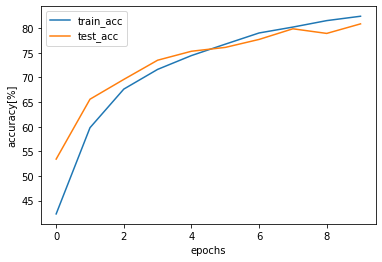

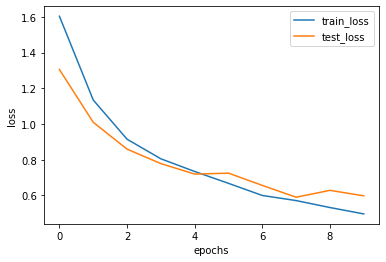

10/01 07:24:15 AM epoch 11
10/01 07:24:15 AM train 000 4.532054e-01 81.250000 98.437500
10/01 07:24:44 AM train 100 4.352028e-01 84.808168 99.443069
10/01 07:25:12 AM train 200 4.508572e-01 84.258396 99.370336
10/01 07:25:40 AM train 300 4.584564e-01 83.850706 99.345930
10/01 07:26:05 AM train_acc 83.836000
10/01 07:26:06 AM valid 000 3.833583e-01 85.937500 100.000000
10/01 07:26:07 AM valid_acc 80.720000
10/01 07:26:08 AM epoch 12
10/01 07:26:09 AM train 000 3.873682e-01 87.500000 100.000000
10/01 07:26:37 AM train 100 4.295164e-01 85.210396 99.535891
10/01 07:27:05 AM train 200 4.391302e-01 84.647077 99.494714
10/01 07:27:33 AM train 300 4.406619e-01 84.665698 99.460133
10/01 07:27:59 AM train_acc 84.536000
10/01 07:27:59 AM valid 000 4.863817e-01 82.812500 100.000000
10/01 07:28:01 AM valid_acc 79.480000
10/01 07:28:01 AM epoch 13
10/01 07:28:02 AM train 000 3.591257e-01 92.187500 100.000000
10/01 07:28:30 AM train 100 3.928408e-01 86.154084 99.597772
10/01 07:28:59 AM train 200 4.0

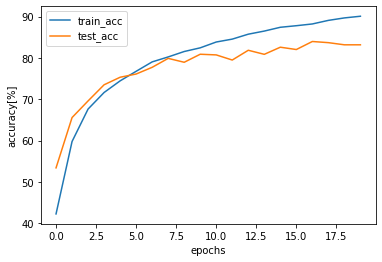

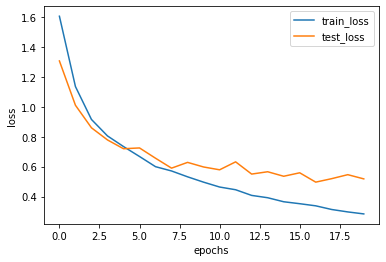

10/01 07:44:07 AM epoch 21
10/01 07:44:08 AM train 000 1.985857e-01 92.187500 100.000000
10/01 07:44:36 AM train 100 2.727819e-01 90.702351 99.798886
10/01 07:45:04 AM train 200 2.601351e-01 90.928172 99.852301
10/01 07:45:32 AM train 300 2.629698e-01 90.770349 99.833887
10/01 07:45:57 AM train_acc 90.604000
10/01 07:45:57 AM valid 000 3.461747e-01 85.937500 100.000000
10/01 07:45:59 AM valid_acc 84.680000
10/01 07:46:00 AM epoch 22
10/01 07:46:00 AM train 000 2.861268e-01 87.500000 100.000000
10/01 07:46:29 AM train 100 2.387590e-01 91.785272 99.829827
10/01 07:46:57 AM train 200 2.574983e-01 90.819341 99.813433
10/01 07:47:25 AM train 300 2.589643e-01 90.728821 99.833887
10/01 07:47:50 AM train_acc 90.788000
10/01 07:47:50 AM valid 000 3.852417e-01 89.062500 100.000000
10/01 07:47:52 AM valid_acc 84.320000
10/01 07:47:53 AM epoch 23
10/01 07:47:53 AM train 000 2.264747e-01 92.187500 100.000000
10/01 07:48:22 AM train 100 2.325593e-01 92.094678 99.798886
10/01 07:48:51 AM train 200 2.

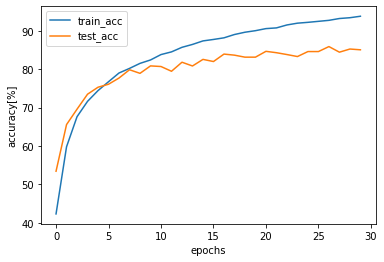

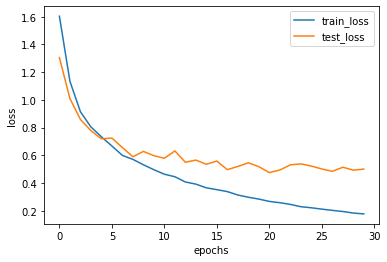

10/01 08:03:25 AM epoch 31
10/01 08:03:25 AM train 000 8.797280e-02 95.312500 100.000000
10/01 08:03:54 AM train 100 1.508026e-01 94.740099 99.969059
10/01 08:04:22 AM train 200 1.581382e-01 94.519590 99.953358
10/01 08:04:51 AM train 300 1.682267e-01 94.186047 99.948090
10/01 08:05:16 AM train_acc 94.064000
10/01 08:05:16 AM valid 000 5.865219e-01 81.250000 100.000000
10/01 08:05:18 AM valid_acc 83.820000
10/01 08:05:19 AM epoch 32
10/01 08:05:20 AM train 000 1.494771e-01 95.312500 100.000000
10/01 08:05:54 AM train 100 1.646660e-01 94.275990 99.969059
10/01 08:06:22 AM train 200 1.673677e-01 94.022077 99.953358
10/01 08:06:50 AM train 300 1.699551e-01 94.019934 99.942899
10/01 08:07:16 AM train_acc 93.964000
10/01 08:07:16 AM valid 000 3.467486e-01 87.500000 100.000000
10/01 08:07:18 AM valid_acc 84.580000
10/01 08:07:19 AM epoch 33
10/01 08:07:19 AM train 000 3.075238e-01 92.187500 100.000000
10/01 08:07:48 AM train 100 1.550207e-01 94.616337 99.922649
10/01 08:08:16 AM train 200 1.

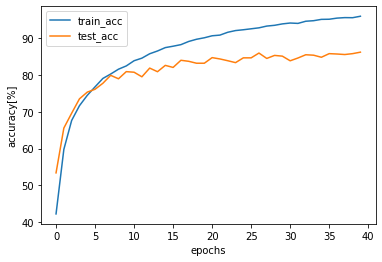

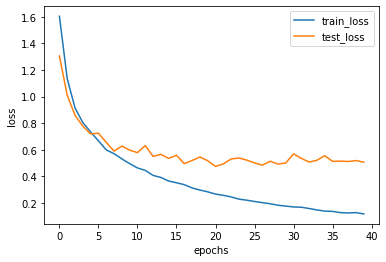

10/01 08:23:26 AM epoch 41
10/01 08:23:26 AM train 000 8.550093e-02 96.875000 100.000000
10/01 08:23:55 AM train 100 1.054144e-01 96.132426 99.984530
10/01 08:24:23 AM train 200 1.046506e-01 96.206468 99.992226
10/01 08:24:51 AM train 300 1.109448e-01 96.023671 99.989618
10/01 08:25:16 AM train_acc 96.008000
10/01 08:25:16 AM valid 000 6.843764e-01 81.250000 100.000000
10/01 08:25:18 AM valid_acc 85.760000
10/01 08:25:19 AM epoch 42
10/01 08:25:19 AM train 000 1.527890e-01 92.187500 100.000000
10/01 08:25:47 AM train 100 1.161082e-01 95.869431 99.984530
10/01 08:26:16 AM train 200 1.187911e-01 95.825560 99.984453
10/01 08:26:44 AM train 300 1.161277e-01 95.971761 99.968854
10/01 08:27:10 AM train_acc 95.916000
10/01 08:27:10 AM valid 000 5.033306e-01 85.937500 100.000000
10/01 08:27:12 AM valid_acc 85.940000
10/01 08:27:13 AM epoch 43
10/01 08:27:14 AM train 000 9.022843e-02 98.437500 100.000000
10/01 08:27:48 AM train 100 1.108972e-01 96.178837 99.984530
10/01 08:28:16 AM train 200 1.

In [ ]:
if __name__ == '__main__':
  args = {'gene':'VGG19', 'stride_max':2}
  model = load_model(dir="drive/My Drive/ml/exp_vgg19_beta-2020-09-30_19-53-32", **args)
  
  sampler : ArchitectureSampler = MaxSampler()
  graph = model.sampled_graph(sampler)

  main(save="exp_vgg19_beta_eval", lr=0.005, momentum=0.9, lr_alpha=0.003, epochs=100, 
       train_size=25000, valid_size=25000, test_size=5000, batch_size=64,
       seed=41, report=100, checkpoint=10, dir="", graph=graph, **args)

In [ ]:
if __name__ == '__main__':
  args = {'gene':'VGG19', 'stride_max':2}
  model = load_model(dir="drive/My Drive/ml/exp_vgg19_beta-2020-09-30_19-53-32", **args)
  
  sampler : ArchitectureSampler = ForwardSampler()
  graph = model.sampled_graph(sampler)

  main(save="exp_vgg19_beta_eval", lr=0.005, momentum=0.9, lr_alpha=0.003, epochs=100, 
       train_size=25000, valid_size=25000, test_size=5000, batch_size=64,
       seed=41, report=100, checkpoint=10, dir="", graph=graph, **args)

In [ ]:
if __name__ == '__main__':
  model = load_model(dir="exp_beta_test-2020-09-30_14-22-10")
  
  sampler : ArchitectureSampler = ForwardSampler()
  graph = model.sampled_graph(sampler)

  main(save="exp_beta_test_base", lr=0.01, momentum=0.9, lr_alpha=0.003, epochs=100, 
       train_size=25000, valid_size=25000, test_size=5000, batch_size=64,
       gene='VGG11',
       seed=41, report=100, checkpoint=10, dir="", graph=graph)

In [ ]:
if __name__ == '__main__':
  args = {'gene':'VGG19', 'stride_max':2}
  model = load_model(dir="exp_vgg19-2020-09-24_15-22-36", **args)
  
  sampler : ArchitectureSampler = MaxSampler()
  graph = model.sampled_graph(sampler)
  main(save="exp_vgg19_eval", lr=0.01, momentum=0.9, lr_alpha=0.003, epochs=100, 
       train_size=25000, valid_size=25000, test_size=5000, batch_size=64,
       seed=41, report=100, checkpoint=10, dir="", graph=graph, **args)
  

In [ ]:
if __name__ == '__main__':
  model = load_model(dir="exp-2020-09-24_08-53-44")
  
  # sampler : ArchitectureSampler = ForwardSampler()
  # graph = model.sampled_graph(sampler)
  # main(save="exp_eval_forward", lr=0.01, momentum=0.9, lr_alpha=0.0, epochs=100, 
  #     train_size=25000, valid_size=25000, test_size=5000, batch_size=64, 
  #     seed=41, report=100, checkpoint=10, dir="", graph=graph)
  
  sampler : ArchitectureSampler = MaxSampler()
  graph = model.sampled_graph(sampler)
  main(save="exp_eval_max", lr=0.01, momentum=0.9, lr_alpha=0.0, epochs=100, 
      train_size=25000, valid_size=25000, test_size=5000, batch_size=64, 
      seed=41, report=100, checkpoint=10, dir="", graph=graph)
  

# exp

TODO
- watch model size, memory
- early stopping